In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels

import seaborn as sns
import stargazer

# Table of Contents:

1. Introduction
2. Data Sources
3. A Theoretically Sound Set of Policies
4. Data Plotting and Summary Statistics
5. Modelling
6. Conclusions

# 1. Introduction

## Do guns cause violence? Evidence from US state-level gun laws, 1991-2014


This project is about what impact state-level gun control laws have on violent crime in the United States. I use two datasets from Kaggle (a data science community site where datasets and projects are shared) and a differences-in-differences model (which analyzes the impacts of varying treatments across different entities over time).

Proponents of gun control would argue that reducing the availability of firearms makes them harder for criminals to acquire and use to break the law. This makes criminal activities more difficult, creating a dissuasion effect, where tighter gun laws make crime rarer. In contrast, gun rights activists often claim this is not the case, and the regulations will not prevent criminals from acquiring firearms, ie. a claim that the dissuasion effect is zero. As well, they typically argue that loose gun laws makes firearms available to ordinary citizens, raising the risk of robbing or assaulting any random citizen due to the likelihood he is armed. This "good guy with a gun" or self-defense effect would raise the costs of criminal activity, meaning that increased firearm availability would instead *reduce crime*.

Due to the opposite directions of the dissuasion and self-defense effects, an empirical test can determine which, if either, dominates, and whether gun restrictions can make states safer. 

## The Differences-in-Differences Model

Enter the "Differences-in-Differences" model. Under its simplest form, it takes two entities (such as states, regions, municipalities, firms, etc) which have a "common trend" in the outcome variable. Imagine two neighboring states with similar crime levels, for example. It analyzes a period in which one entity is subjected to a treatment - in this case, a change in gun availability - to see how the treated group diverges from the common trend. 

In this case, I will be using all 50 American states, with a dataset containing their gun laws from 1991-2017, and their homicide cases from 2001-2016, leading to a shared coverage of 2001-2016. With 50 states and 16 years, this yields 800 total observations. The gun laws dataset was uploaded to Kaggle, available [here](https://www.kaggle.com/jboysen/state-firearms), as part of the State Firearm Laws project. It assigns 1 and 0 values to each of 133 provisions by state and year, 1 when a provision exists, 0 when it does not. The state-level crime data is taken from [Crime and Incarceration in the United States](https://www.kaggle.com/christophercorrea/prisoners-and-crime-in-united-states), a Kaggle dataset uploaded by ChrisC, assembled from several US Government data sources. 

The model will regress several crime types (measured per 100,000 citizens) on the state-level gun control indices, as well as state fixed effects, year fixed effects, and linear and quadratic state-time effects, to allow for varying crime trends in individual states. 

In layman's terms, the model tests the effect of varying (and changing) levels of gun control laws in each state over time. It holds constant fixed traits of each state and year, and allows for states to have differing, linear and non-linear crime trends. If these controls are deemed sufficient, then the 

### Limitations

The main inspiration for this model comes from Angrist and Pischke's "Mastering 'Metrics" book, where differences-in-differences models are explained through cases on state-level minimum legal drinking age laws and their impact upon deaths (largely through traffic fatalities). 

While broadly similar (government restrictions on access to a potentially dangerous good) the issue remains that alcohol is a one-time consumable, while properly-maintained firearms are highly durable. As well, relative to mass, firearms are much more costly than is alcohol. It is easy to expect buyers to cross state lines to purchase weapons, and/or moving weapons illegally between states, and a large supply of weapons in owners' hands (and therefore available in the secondary market) can persist despite stricter regulations.

Some other limiations are that other policy choices may come into effect at the same time as changes in gun control. The main type I have in mind are "tough on crime" legislation. However, due to the highly partisan and polarized nature of US politics in this period, this may not be a concern. 

The Republican Party is associated with tough-on-crime and pro-police stances, as well as light gun control, while the Democratic Party is associated with less strict crime laws, openness to police reform, and tight gun controls. I would expect tough-on-crime laws to be more likely to reduce crime levels more than the Democratic alternative. This would mean that other legislation likely to reduce crime would correlate with legislation loosening gun controls, and vice-versa, meaning that if there is any bias, it would make tighter gun laws associated with slightly higher levels of crime than otherwise.

In other words, I would expect omitted variable bias (from other crime legislation) to make a tightening of gun laws appear to have a smaller crime reduction effect, or larger crime increase effect, than it actually does on its own. 

In this fairly rudimentary model, other newly-introduced legislation is not accounted for, nor is the existing supply of firearms (though state fixed effects may capture part of it).

# 2. Data  Sources


I use merged two data sources for this project. Both are from Kaggle, a data science community website. They are composed of yearly observations of each US state.

### [Firearm regulations in the U.S.](https://www.kaggle.com/jonathanbouchet/firearm-regulations-in-the-u-s)


Created by Jonathan Bouchet, this dataset codes a set of 133 firearm restriction (ie. gun control laws), for all 50 states from 1991-2017. If a gun control law exists, it is coded with 1, and otherwise with 0. 



### [Crime and Incarceration in the United States](https://www.kaggle.com/christophercorrea/prisoners-and-crime-in-united-states)

Created by Chris Correa, this dataset contains data on crimes committed and prisoner counts in every 50 state, covering 2001-2017. Of most interest are three crime types: `violent_crime_total`, `murder_manslaughter`, and `agg_assault`. These are divided by state population in each year and multiplied by 100,000 to create three crime rates: total Violent Crimes per 100,000 citizens, murders and manslaughter rate per 100,000 citizens, and aggravated assaults per 100,000 citizens.



### Why am I not using gun violence data?

My interest is in whether gun restrictions reduce Violent Crime. A critic of gun control may suggest that criminals will simply substitute to other weapons, such as blades, if guns are unavailable. I want to find if making crime more difficult through weapons restrictions reduces overall crime levels, and therefore I use these weapon-agnostic data as the dependent variable.




### Missing Value:

Crime data is missing for New York in 2015. It registered a mild increase in Murder/Manslaughter from 2014-2016, and a moderate decrease in other types of crime. I will plot a chart displaying the trends later; for the purposes of this project I will just backfill 2015 with the 2014 values.

As this is one observation for one state in one year, I doubt it will impact results however it is resolved. 

# 3. A Theoretically Sound Set of Policies

While I will not be deriving a model mapping gun availability to gun violence, I'm interested in looking at the impact of policies believed by researchers to be more consequential.

[Growing Evidence About the Effects of Gun Policies Provides Needed Information for Policy Decisions](https://www.rand.org/news/press/2020/04/22.html) is a publication by RAND researchers, discussing some policy areas that have been shown to have impacts on gun violence. A related page [here](https://www.rand.org/research/gun-policy.html) visualizes policies, their impacts on various outcomes (such as violent crime and gun suicides) and the strength of evidence for their impacts. The policies listed as having decent-quality evidence of working are:

- Stand-your-ground laws (which increase Violent Crime)
- Restrictions on gun ownership among domestic violence offenders (reduces homicides)
- Waiting periods (reduces total homicides)
- Restrictions on gun ownership for the mentally-ill (reduces Violent Crime)
- Right-to-carry (increases Violent Crime)

I restricted the gun laws dataframe to just include regulations associated with these topics, reducing to a total of 46 regulations. These were then summed for each state-year entry and divided by 46, to create an index of gun law strictness.

Again, the issue with this approach is that not all gun laws are created equally, and even among those suggested by researchers as reducing violence, some will be more effective than others. For now, however, they should provide a simple metric of gun law strictness.

My dataset below is the gun and crime datasets joined, with `selected_policies_index` computed by adding up the total of a state's firearm restrictions from a set of 46 chosen as matching the RAND policies suggested above, then dividing by 46, to get an index from 0 to 1 showing how many restrictions are in place. I also added variables for each state, year, time (calculated as the year minus 2000), and time squared for the quadratic trend effect.

In [2]:
sel_pol_url = "https://docs.google.com/spreadsheets/d/1qzzQOoNJDZegcDX2XPbg8gXITg5wW6ryoAoYJDqmzQE/edit#gid=1322467741"

url_sel_pol = sel_pol_url.replace("/edit#gid=", "/export?format=csv&gid=")

sel_pol_df = pd.read_csv(url_sel_pol)

sel_pol_df.head()

,nosyg,permitconcealed,mayissue,showing,ccrevoke,ccbackground,ccbackgroundnics,ccrenewbackground,universal,universalh,...,selected_policies_index,state_year,violent_crime_100k,murder_manslaughter_100k,agg_assault_100k,property_crime_total_100k,state,year,time,time_squared
0,1,1,1,1,0,0,0,0,0,0,...,0.108696,ALABAMA 2001,438.182717,8.480811,274.115937,3876.849667,Alabama,2001,1,1
1,1,1,0,0,1,1,0,0,0,0,...,0.086957,ALASKA 2001,589.460726,6.155012,423.117592,3655.129965,Alaska,2001,1,1
2,1,1,0,0,1,1,0,1,0,0,...,0.260870,ARIZONA 2001,540.327562,7.537263,337.085257,5537.514278,Arizona,2001,1,1
3,1,1,0,0,1,1,1,1,0,0,...,0.195652,ARKANSAS 2001,452.369802,5.492267,332.838782,3677.814731,Arkansas,2001,1,1
4,1,1,1,1,1,1,0,1,1,1,...,0.760870,CALIFORNIA 2001,615.214311,6.375637,393.309766,3277.959026,California,2001,1,1


# 4.  Plots and Summary Statistics

- 4.1 Violent Crime Mean and Standard Deviation 
- 4.2 Over-time Crime values for five states
- 4.3 selected_policies_index Regression Plot

## 4.1 Violent Crime Mean and Standard Deviations

In [3]:
year_avgs = sel_pol_df.groupby("year").mean()
year_avgs

,nosyg,permitconcealed,mayissue,showing,ccrevoke,ccbackground,ccbackgroundnics,ccrenewbackground,universal,universalh,...,expartesurrenderdating,dvroremoval,stalking,selected_policies_index,violent_crime_100k,murder_manslaughter_100k,agg_assault_100k,property_crime_total_100k,time,time_squared
year,,,,,,,,,,,,,,,,,,,,,
2001,0.98,0.98,0.36,0.30,0.64,0.80,0.18,0.64,0.06,0.10,...,0.06,0.02,0.32,0.222174,420.341824,4.693285,272.506079,3585.812351,1.0,1.0
2002,0.98,0.98,0.36,0.30,0.64,0.84,0.18,0.64,0.06,0.10,...,0.06,0.02,0.34,0.225217,413.708703,4.654458,267.353078,3565.396104,2.0,4.0
2003,0.98,0.96,0.30,0.26,0.66,0.82,0.20,0.66,0.06,0.10,...,0.08,0.02,0.32,0.228696,403.804347,4.755063,259.579174,3510.411796,3.0,9.0
2004,0.98,0.96,0.28,0.24,0.68,0.84,0.18,0.68,0.06,0.10,...,0.08,0.02,0.32,0.233478,397.243345,4.660130,257.454552,3430.747045,4.0,16.0
2005,0.96,0.96,0.28,0.24,0.68,0.84,0.18,0.68,0.06,0.10,...,0.08,0.02,0.32,0.234783,401.533989,4.752509,259.755762,3356.759198,5.0,25.0
2006,0.74,0.96,0.28,0.24,0.68,0.88,0.26,0.72,0.06,0.10,...,0.08,0.02,0.32,0.237826,421.837820,4.988067,269.884848,3267.851760,6.0,36.0
2007,0.70,0.96,0.24,0.20,0.68,0.88,0.24,0.70,0.06,0.10,...,0.08,0.02,0.32,0.234348,418.232294,4.999577,268.583442,3184.959865,7.0,49.0
2008,0.68,0.96,0.24,0.20,0.68,0.90,0.24,0.70,0.06,0.10,...,0.10,0.02,0.32,0.237826,407.620573,4.766291,259.895643,3103.915459,8.0,64.0
2009,0.66,0.96,0.24,0.20,0.70,0.90,0.24,0.70,0.06,0.10,...,0.10,0.02,0.32,0.243913,387.680134,4.385547,249.738749,2951.514427,9.0,81.0


In [4]:
vnt_crm_avg = str(round(year_avgs["violent_crime_100k"].mean(), 2))
mur_man_avg = str(round(year_avgs["murder_manslaughter_100k"].mean(), 2))
ag_aslt_avg = str(round(year_avgs["agg_assault_100k"].mean(), 2))

vnt_crm_std = str(round(year_avgs["violent_crime_100k"].std(), 2))
mur_man_std = str(round(year_avgs["murder_manslaughter_100k"].std(), 2))
ag_aslt_std = str(round(year_avgs["agg_assault_100k"].std(), 2))

print(f"Overall Violent Crime has an average of {vnt_crm_avg} cases per 100,000 citizens, with a standard deviation of {vnt_crm_std}")
print(f"There is an average of {mur_man_avg} Murder and Manslaughter cases per 100,000 citizens, with a standard deviation of {mur_man_std}")
print(f"There is an average of {ag_aslt_avg} Aggravated Assault cases per 100,000 citizens, with a standard deviation of {ag_aslt_std}")

Overall Violent Crime has an average of 386.64 cases per 100,000 citizens, with a standard deviation of 27.22
There is an average of 4.56 Murder and Manslaughter cases per 100,000 citizens, with a standard deviation of 0.33
There is an average of 249.78 Aggravated Assault cases per 100,000 citizens, with a standard deviation of 16.96


While the standard deviations cannot be directly compared meaningfully, we can use the coefficient of variation, equal to standard deviation divided by mean value, to see which vary more. 

- Violent Crime CoV = 0.0704
- Murder/Manslaughter CoV = 0.0724
- Aggravated Assault CoV = 0.0679

So, when looking across all states and years the amount to which these vary year-by-year is near-identical. I would assume that types of Violent Crime are positively correlated; years with more murders likely have more assaults as well, though the comparable coefficients of variance could be caused by other factors. 

I'd like to display these three variables as histograms, to see if some are more widely dispersed than others.

In [5]:
vnt_crm_base = sel_pol_df["violent_crime_100k"]

mur_man_base = sel_pol_df["murder_manslaughter_100k"]

ag_aslt_base = sel_pol_df["agg_assault_100k"]

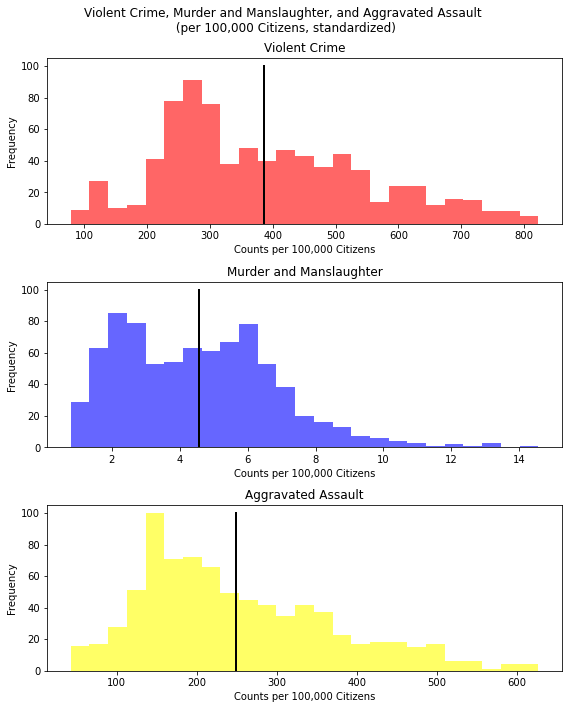

In [6]:
fig, ax = plt.subplots(3, 1, figsize = (8, 10))
fig.suptitle("Violent Crime, Murder and Manslaughter, and Aggravated Assault \n (per 100,000 Citizens, standardized)")

plt.xlabel('Z-Values')
plt.ylabel('Frequency')

ax[0].hist(vnt_crm_base, bins = 25, alpha = 0.6, color = "red")
ax[0].set_title("Violent Crime")
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Counts per 100,000 Citizens')
ax[0].plot([386.64, 386.64], [0, 100], "k-", lw=2)



ax[1].hist(mur_man_base, bins = 25, alpha = 0.6, color = "blue")
ax[1].set_title("Murder and Manslaughter")
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Counts per 100,000 Citizens')
ax[1].plot([4.56, 4.56], [0, 100], "k-", lw=2)

ax[2].hist(ag_aslt_base, bins = 25, alpha = 0.6, color = "yellow")
ax[2].set_title("Aggravated Assault")
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Counts per 100,000 Citizens')
ax[2].plot([249.78, 249.78], [0, 100], "k-", lw=2)

fig.tight_layout()

In all three crime types, standardized or not, we can observe that in overall violence and Aggravated Assault, most observation values are below the mean (marked by a vertical black line), with a long right tail. Murder and Manslaughter has two peaks, at around 2 and 6 cases per 100,000 citizens, also with a long right tail. Overall Violent Crime, counting a large class of crimes, has the greatest x-axis values. Aggravated Assault has high but lower levels, while Murder and Manslaughter rates are far lower: compare the mean of just over 4 to the Aggravated Assault mean of approximately 250. 

While useful, we are also interested in how much the different rates vary, year to year, *within* states, which this doesn't tell us.

## 4.2 Over-time Crime values for five states

I cannot plot all fifty states. As I want a mix of population levels, I've decided to use the first, eleventh, twenty-first, thirty-first, and fourty-first largest states (in terms of population). This is:

- California
- New Jersery
- Clorodo
- Iowa
- New Hampshire

I will extract these from the dataset, then plot their crime values year-by-year as a line chart with five lines.

In [7]:
# taking the five states

cali = sel_pol_df[sel_pol_df["state"] == "California"]
joisey = sel_pol_df[sel_pol_df["state"] == "New Jersey"]
colorado = sel_pol_df[sel_pol_df["state"] == "Colorado"]
iowa = sel_pol_df[sel_pol_df["state"] == "Iowa"]
new_hamp = sel_pol_df[sel_pol_df["state"] == "New Hampshire"]

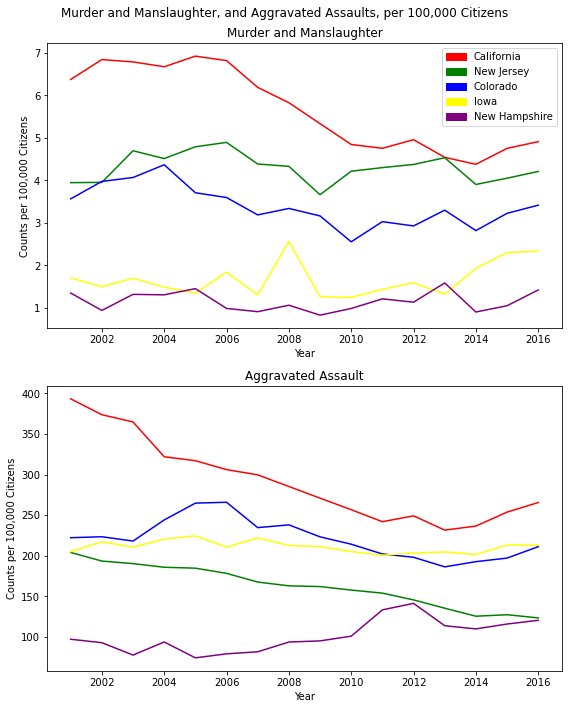

In [8]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(2, 1, figsize = (8, 10))

years = np.arange(2001, 2017)
years

fig.suptitle("Murder and Manslaughter, and Aggravated Assaults, per 100,000 Citizens")

#plt.xlabel('Z-Values')
#plt.ylabel('Frequency')


ax[0].plot(years, cali["murder_manslaughter_100k"], color = "red")
ax[0].plot(years, joisey["murder_manslaughter_100k"], color = "green")
ax[0].plot(years, colorado["murder_manslaughter_100k"], color = "blue")
ax[0].plot(years, iowa["murder_manslaughter_100k"], color = "yellow")
ax[0].plot(years, new_hamp["murder_manslaughter_100k"], color = "purple")
ax[0].set_title("Murder and Manslaughter")
ax[0].set_ylabel('Counts per 100,000 Citizens')
ax[0].set_xlabel('Year')



ax[1].plot(years, cali["agg_assault_100k"], color = "red")
ax[1].plot(years, joisey["agg_assault_100k"], color = "green")
ax[1].plot(years, colorado["agg_assault_100k"], color = "blue")
ax[1].plot(years, iowa["agg_assault_100k"], color = "yellow")
ax[1].plot(years, new_hamp["agg_assault_100k"], color = "purple")
ax[1].set_title("Aggravated Assault")
ax[1].set_ylabel('Counts per 100,000 Citizens')
ax[1].set_xlabel('Year')


red_patch = mpatches.Patch(color='red', label='California')
green_patch = mpatches.Patch(color='green', label='New Jersey')
blue_patch = mpatches.Patch(color='blue', label='Colorado')
yellow_patch = mpatches.Patch(color='yellow', label='Iowa')
purple_patch = mpatches.Patch(color='purple', label='New Hampshire')


ax[0].legend(handles=[red_patch, green_patch, blue_patch, yellow_patch, purple_patch])


fig.tight_layout()

Just from visual inspection, there doesn't seem to be any drastic yearly variance in either crime type. Murder rates trended downwards in California over the sample period, with minimal trends in other states, though there seems to have been a slight downward trend in Aggravated Assaults in most states. 

- California saw a fairly large drop in in murder rate and Aggravated Assaults
- New Jersey saw a slight rise and fall (back to original levels) in murder rate, though a notable decline in Aggravated Assaults
- Colorado saw a slight fall in murder rates and little overall change in Aggravated Assaults
- Iowa saw a murder spike in 2008, but otherwise little trend in murders. Perhaps a rise from 2014 onwards. Aggravated Assaults were almost constant.
- New Hampshire saw a flat trend in murder rates and a mild rise in aggravated assaults.

Without a more rigorous testing process I cannot conclude one way or the other, but the visual inspection seems to imply murder rates didn't change much overall in any state but California. This is just being done to get an idea of what values looked like - other states were likely different, and we cannot conclude anything causal from the visual inspection.

In [9]:
# Correlation of murder rate, aggravated assault rate, with `selected_policies_index`

# Average by year then display.

sel_pol_df_state = sel_pol_df.groupby("state").mean()
sel_pol_df_state.head()

,nosyg,permitconcealed,mayissue,showing,ccrevoke,ccbackground,ccbackgroundnics,ccrenewbackground,universal,universalh,...,dvroremoval,stalking,selected_policies_index,violent_crime_100k,murder_manslaughter_100k,agg_assault_100k,property_crime_total_100k,year,time,time_squared
state,,,,,,,,,,,,,,,,,,,,,
Alabama,0.3125,1.0000,0.75,0.75,0.0,0.6875,0.25,0.25,0.0,0.0,...,0.00,0.6875,0.112772,441.628213,7.171962,276.578734,3672.175262,2008.5,8.5,93.5
Alaska,0.7500,0.1250,0.00,0.00,1.0,0.1250,0.00,0.00,0.0,0.0,...,0.00,0.0000,0.043478,644.441898,5.267850,464.462766,3188.420705,2008.5,8.5,93.5
Arizona,0.5625,0.5625,0.00,0.00,1.0,1.0000,0.00,1.00,0.0,0.0,...,0.00,1.0000,0.241848,471.897096,6.600644,300.625919,4196.529416,2008.5,8.5,93.5
Arkansas,1.0000,1.0000,0.00,0.00,1.0,1.0000,1.00,1.00,0.0,0.0,...,0.00,0.7500,0.190217,497.353998,6.060636,359.810321,3701.326390,2008.5,8.5,93.5
California,1.0000,1.0000,1.00,1.00,1.0,1.0000,0.00,1.00,1.0,1.0,...,0.25,1.0000,0.830163,488.950962,5.682356,291.805411,2933.978368,2008.5,8.5,93.5


## 4.3 `selected_policies_index` Regression Plot

What I'm doing next is a correlation of the index of gun control measures in each state-year observation, and the state-year's violent crime levels. This will show if states with more violence tend to have more or fewer gun restrictions.

On the plot below, the two left-hand plots are using every state-year observation, while the right-hand plots use each state's averaged values across the years. 

In [10]:
# Correlation of murder rate, aggravated assault rate, with `selected_policies_index`

# Average by year then display.

sel_pol_df_state = sel_pol_df.groupby("state").mean()
sel_pol_df_state.head()

,nosyg,permitconcealed,mayissue,showing,ccrevoke,ccbackground,ccbackgroundnics,ccrenewbackground,universal,universalh,...,dvroremoval,stalking,selected_policies_index,violent_crime_100k,murder_manslaughter_100k,agg_assault_100k,property_crime_total_100k,year,time,time_squared
state,,,,,,,,,,,,,,,,,,,,,
Alabama,0.3125,1.0000,0.75,0.75,0.0,0.6875,0.25,0.25,0.0,0.0,...,0.00,0.6875,0.112772,441.628213,7.171962,276.578734,3672.175262,2008.5,8.5,93.5
Alaska,0.7500,0.1250,0.00,0.00,1.0,0.1250,0.00,0.00,0.0,0.0,...,0.00,0.0000,0.043478,644.441898,5.267850,464.462766,3188.420705,2008.5,8.5,93.5
Arizona,0.5625,0.5625,0.00,0.00,1.0,1.0000,0.00,1.00,0.0,0.0,...,0.00,1.0000,0.241848,471.897096,6.600644,300.625919,4196.529416,2008.5,8.5,93.5
Arkansas,1.0000,1.0000,0.00,0.00,1.0,1.0000,1.00,1.00,0.0,0.0,...,0.00,0.7500,0.190217,497.353998,6.060636,359.810321,3701.326390,2008.5,8.5,93.5
California,1.0000,1.0000,1.00,1.00,1.0,1.0000,0.00,1.00,1.0,1.0,...,0.25,1.0000,0.830163,488.950962,5.682356,291.805411,2933.978368,2008.5,8.5,93.5


[Text(0, 0.5, '')]

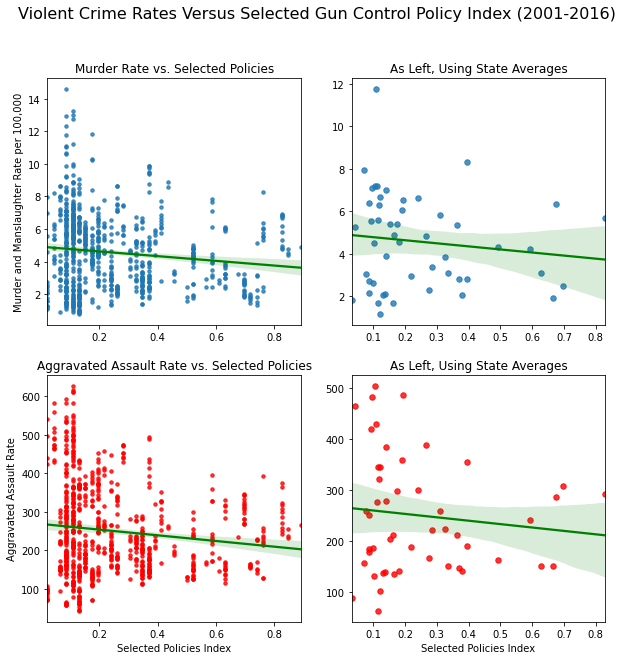

In [11]:
fix, axs = plt.subplots(2, 2,  figsize=(10, 10))
#fig, axs = plt.subplots(nrows=4, figsize=(8, 16))


plt.suptitle('Violent Crime Rates Versus Selected Gun Control Policy Index (2001-2016)', fontsize = 16)


sns.regplot(x = "selected_policies_index", y = "murder_manslaughter_100k", 
            data = sel_pol_df, ax=axs[0, 0], line_kws={"color": "green"}, scatter_kws={'s':12})
axs[0, 0].set(ylabel='Murder and Manslaughter Rate per 100,000')
axs[0, 0].set_title('Murder Rate vs. Selected Policies')
axs[0, 0].set(xlabel=None)

sns.regplot(x = "selected_policies_index", y = "agg_assault_100k", 
            data = sel_pol_df, color = "red", ax = axs[1, 0], 
            line_kws={"color": "green"}, scatter_kws={'s':12})
axs[1, 0].set(xlabel='Selected Policies Index', ylabel='Aggravated Assault Rate')
axs[1, 0].set_title('Aggravated Assault Rate vs. Selected Policies')

sns.regplot(x = "selected_policies_index", y = "murder_manslaughter_100k", 
            data = sel_pol_df_state, ax = axs[0, 1], line_kws={"color": "green"}, scatter_kws={'s':30})
axs[0, 1].set(ylabel='Murder and Manslaughter rate per 100,000')
axs[0, 1].set_title('As Left, Using State Averages')
axs[0, 1].set(xlabel=None)
axs[0, 1].set(ylabel=None)


sns.regplot(x = "selected_policies_index", y = "agg_assault_100k", 
            data = sel_pol_df_state, color = "red", ax = axs[1, 1], line_kws={"color": "green"},
           scatter_kws={'s':30})
axs[1, 1].set(xlabel='Selected Policies Index', ylabel='Aggravated Assault rate per 100,000')
axs[1, 1].set_title('As Left, Using State Averages')
axs[1, 1].set(ylabel=None)

The top row columns (with scattered points in blue) are the murder rate correlations, where the number of Murders and Manslaughters is regressed on the value of the selected gun policies. The green line is the best fit line, with a confidence interval shaded around it. The downward slope shows a negative association between murder rates and gun controls.

The bottom row is the Aggravated Assault models, again showing the best-fit line between the Aggravated Assault rate and selected gun policy index values. 

The left columns have far more scattered dots: these are using every state's value in every year as an individual data point. The right-hand column plots have only fifty values each: each of these is a state's values averaged over every year in the dataset. Because there are fewer observations the confidence interval is much wider. While the state average plots are easier to look at, the left-hand column plots are likely superior. 

# 5. Modelling

## 5.1 Selected Policies Index Models (Quadratic Time Trend)

Now we begin the modelling. As a reminder, the model accounts for the following :

- state fixed effects (traits specific to each state which do not change over time; eg. local gun use traditions)
- year fixed effects (specific features of each year which impact every state equally; eg. yearly economic shocks, federal legislation)
- linear time trends of each state (a state trend increasing or decreasing crime by the same amount every year; eg. a shrinking cohort of crime-prone young men)
- quadratic time trends of each state (as with linear time trends, but the effect is multiplied by time squared and is different each year)

If these are assumed to account for all (or nearly all) other variation/bias in crime levels, the estimates of `selected_policies_index` should show the impact of going from none of the recommended policies, to implementing all of them. 

In [12]:
# USING sel_pol_df
# violent crime (selected policies index)

diff_in_diff = smf.ols(formula = "violent_crime_100k ~ selected_policies_index +  time * C(state) + C(state) * time_squared + C(state) + C(year)",
                      data = sel_pol_df)

diff_in_diff_result = diff_in_diff.fit(cov_type='cluster', 
                                       cov_kwds={'groups': np.array(sel_pol_df[["state", "year"]], dtype = "str")
})
diff_in_diff_result.summary()

C:\Users\jonah\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 165, but rank is 164
  warnings.warn('covariance of constraints does not have full '
C:\Users\jonah\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1817: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     violent_crime_100k   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                    -3697.
Date:                Thu, 17 Jun 2021   Prob (F-statistic):               1.00
Time:                        16:16:29   Log-Likelihood:                -3460.8
No. Observations:                 800   AIC:                             7250.
Df Residuals:                     636   BIC:                             8018.
Df Model:                         163                                         
Covariance Type:              cluster                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 464.4013      8.959     51.834      0.000     446.841     481.961
C(state)[T.Alaska]                        144.9272        nan        nan        nan         nan         nan
C(state)[T.Arizona]                       134.2875        nan        nan        nan         nan         nan
C(state)[T.Arkansas]                      -11.5902      9.791     -1.184      0.236     -30.779       7.599
C(state)[T.California]                    254.5869     31.989      7.959      0.000     191.891     317.283
C(state)[T.Colorado]                      -83.9414        nan        nan        nan         nan         nan
C(state)[T.Connecticut]                  -103.3430     25.392     -4.070      0.000    -153.110     -53.576
C(state)[T.Delaware]                      138.2490      7.521     18.382      0.000     123.508     152.990
C(state)[T.Florida]                       355.3242      7.436     47.784      0.000     340.750     369.899
C(state)[T.Georgia]                        20.6568     15.159      1.363      0.173      -9.055      50.368
C(state)[T.Hawaii]                       -175.2913     13.986    -12.533      0.000    -202.703    -147.880
C(state)[T.Idaho]                        -208.7319        nan        nan        nan         nan         nan
C(state)[T.Illinois]                      227.2048     22.679     10.018      0.000     182.754     271.655
C(state)[T.Indiana]                       -78.0036      8.707     -8.959      0.000     -95.068     -60.939
C(state)[T.Iowa]                         -181.7080        nan        nan        nan         nan         nan
C(state)[T.Kansas]                        -53.5229     10.583     -5.057      0.000     -74.266     -32.780
C(state)[T.Kentucky]                     -211.6870      5.157    -41.050      0.000    -221.794    -201.580
C(state)[T.Louisiana]                     221.3449      5.258     42.098      0.000     211.040     231.650
C(state)[T.Maine]                        -363.1887     14.262    -25.466      0.000    -391.141    -335.236
C(state)[T.Maryland]                      387.2188      4.043     95.781      0.000     379.295     395.143
C(state)[T.Massachusetts]                  67.6667     28.107      2.407      0.016      12.579     122.755
C(state)[T.Michigan]                       88.5371     12.014      7.370      0.000      64.990     112.084
C(state)[T.Minnesota]                    -158.7268     11.401    -13.922      0.000    -181.073    -136.381
C(state)[T.Mississippi]                  -104.5551     10.029    -10.425      0.000    -124.212     -84.898
C(state)[T.Missouri]                      102.1855        nan        nan        nan         nan         nan
C(state)[T.Montana]                       -77.4641        n

In [13]:
# USING sel_pol_df
# murder manslaughter (selected policies index)

diff_in_diff = smf.ols(formula = "murder_manslaughter_100k ~ selected_policies_index +  time * C(state) + time_squared * C(state)  + C(year)",
                      data = sel_pol_df)

diff_in_diff_result = diff_in_diff.fit(cov_type='cluster', 
                                       cov_kwds={'groups': np.array(sel_pol_df[["state", "year"]], dtype = "str")
})


diff_in_diff_result.summary()

C:\Users\jonah\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 165, but rank is 164
  warnings.warn('covariance of constraints does not have full '
C:\Users\jonah\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1817: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     murder_manslaughter_100k   R-squared:                       0.953
Model:                                  OLS   Adj. R-squared:                  0.941
Method:                       Least Squares   F-statistic:                    -707.3
Date:                      Thu, 17 Jun 2021   Prob (F-statistic):               1.00
Time:                              16:16:29   Log-Likelihood:                -580.38
No. Observations:                       800   AIC:                             1489.
Df Residuals:                           636   BIC:                             2257.
Df Model:                               163                                         
Covariance Type:                    cluster                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   7.5399      0.123     61.278      0.000       7.299       7.781
C(state)[T.Alaska]                         -0.5288      0.501     -1.055      0.292      -1.511       0.454
C(state)[T.Arizona]                        -0.0844        nan        nan        nan         nan         nan
C(state)[T.Arkansas]                       -1.6242      0.520     -3.124      0.002      -2.643      -0.605
C(state)[T.California]                     -0.2279      1.053     -0.216      0.829      -2.292       1.836
C(state)[T.Colorado]                       -3.4236      0.794     -4.311      0.000      -4.980      -1.867
C(state)[T.Connecticut]                    -5.1844        nan        nan        nan         nan         nan
C(state)[T.Delaware]                       -5.6536        nan        nan        nan         nan         nan
C(state)[T.Florida]                        -2.6050        nan        nan        nan         nan         nan
C(state)[T.Georgia]                        -0.0871      0.529     -0.165      0.869      -1.124       0.949
C(state)[T.Hawaii]                         -5.1370        nan        nan        nan         nan         nan
C(state)[T.Idaho]                          -5.1143      0.395    -12.959      0.000      -5.888      -4.341
C(state)[T.Illinois]                        0.9112      0.451      2.021      0.043       0.027       1.795
C(state)[T.Indiana]                        -0.8236        nan        nan        nan         nan         nan
C(state)[T.Iowa]                           -6.0011        nan        nan        nan         nan         nan
C(state)[T.Kansas]                         -4.0689      0.479     -8.486      0.000      -5.009      -3.129
C(state)[T.Kentucky]                       -2.6834      0.618     -4.344      0.000      -3.894      -1.473
C(state)[T.Louisiana]                       4.6115      1.152      4.004      0.000       2.354       6.869
C(state)[T.Maine]                          -6.9678        nan        nan        nan         nan         nan
C(state)[T.Maryland]                        2.3431      1.193      1.965      0.049       0.006       4.680
C(state)[T.Massachusetts]                  -5.4112      0.708     -7.639      0.000      -6.800      -4.023
C(state)[T.Michigan]                       -1.1955        nan        nan        nan         nan         nan
C(state)[T.Minnesota]                      -5.0102      0.460    -10.889      0.000      -5.912      -4.108
C(state)[T.Mississippi]                     2.6151      0.216     12.084      0.000       2.191       3.039
C(state)[T.Missouri]                       -1.4670        nan        nan        nan         nan      

In [14]:
# USING sel_pol_df
# aggravated assault per 100k citizens (selected policies index)

diff_in_diff = smf.ols(formula = "agg_assault_100k ~ selected_policies_index +  time * C(state) + time_squared * C(state) + C(state) + C(year)",
                      data = sel_pol_df)

diff_in_diff_result = diff_in_diff.fit(cov_type='cluster', 
                                       cov_kwds={'groups': np.array(sel_pol_df[["state", "year"]], dtype = "str")
})
diff_in_diff_result.summary()

C:\Users\jonah\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 165, but rank is 164
  warnings.warn('covariance of constraints does not have full '
C:\Users\jonah\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1817: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       agg_assault_100k   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                    -794.3
Date:                Thu, 17 Jun 2021   Prob (F-statistic):               1.00
Time:                        16:16:30   Log-Likelihood:                -3225.0
No. Observations:                 800   AIC:                             6778.
Df Residuals:                     636   BIC:                             7546.
Df Model:                         163                                         
Covariance Type:              cluster                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 291.3084      6.402     45.502      0.000     278.760     303.856
C(state)[T.Alaska]                        133.4896     10.402     12.833      0.000     113.102     153.877
C(state)[T.Arizona]                       108.6612      3.396     31.995      0.000     102.005     115.318
C(state)[T.Arkansas]                       40.8483     11.542      3.539      0.000      18.227      63.469
C(state)[T.California]                    185.1405     23.833      7.768      0.000     138.429     231.852
C(state)[T.Colorado]                      -51.7804      8.439     -6.136      0.000     -68.320     -35.241
C(state)[T.Connecticut]                   -80.5550     13.267     -6.072      0.000    -106.559     -54.551
C(state)[T.Delaware]                      134.2356      7.404     18.130      0.000     119.724     148.747
C(state)[T.Florida]                       283.8568      8.584     33.069      0.000     267.033     300.681
C(state)[T.Georgia]                        -5.4133      7.703     -0.703      0.482     -20.512       9.685
C(state)[T.Hawaii]                       -143.3621      9.874    -14.519      0.000    -162.715    -124.009
C(state)[T.Idaho]                         -93.8787        nan        nan        nan         nan         nan
C(state)[T.Illinois]                      145.7258     15.660      9.306      0.000     115.033     176.418
C(state)[T.Indiana]                       -52.1603        nan        nan        nan         nan         nan
C(state)[T.Iowa]                          -74.7104        nan        nan        nan         nan         nan
C(state)[T.Kansas]                        -20.3607      8.239     -2.471      0.013     -36.509      -4.212
C(state)[T.Kentucky]                     -138.3640        nan        nan        nan         nan         nan
C(state)[T.Louisiana]                     169.0678      8.889     19.020      0.000     151.646     186.490
C(state)[T.Maine]                        -229.4836      4.841    -47.402      0.000    -238.972    -219.995
C(state)[T.Maryland]                      254.4265      5.484     46.394      0.000     243.678     265.175
C(state)[T.Massachusetts]                  89.3265     18.459      4.839      0.000      53.147     125.506
C(state)[T.Michigan]                       82.9899        nan        nan        nan         nan         nan
C(state)[T.Minnesota]                    -124.9740     11.078    -11.282      0.000    -146.686    -103.262
C(state)[T.Mississippi]                   -99.3459        nan        nan        nan         nan         nan
C(state)[T.Missouri]                      107.1736        nan        nan        nan         nan         nan
C(state)[T.Montana]                        38.1009      8.3

## `selected_policies_index` Results

The coefficient interpretation is the effect on each crime category of going from a `selected_policies_index` value of 0 (indicating none of the gun policies being in place) to 1 (indicating all being in place). Each crime type is the rate of incidents per 100,000 citizens. The results are:

- Violent Crime:
    - Coefficient = -97.8702
    - Standard Error = 51.73
    - P-value = 0.058

- Murder and Manslaughter:
    - Coefficient = -0.5305
    - Standard Error = 0.791
    - P-value = 0.502

- Aggravated Assault:
    - Coefficient = -72.4294
    - Standard Error = 37.356
    - P-value = 0.053


    
Generic Violent Crime and Aggravated Assault each have qualitatively large and negative effect, but each comes with a large standard error, and the two fall just short of significance at the 5% level. Murder and Manslaughter has a small effect and very insignificant P-value of 0.502. 

The 5% rule is itself arbitrary, but I'd always lean towards caution when interpreting results. I would therefore not reject the null hypotheses that the effect on each of the three is zero.

Interestingly, the effects on general Violent Vrime and Aggravated Assault are far closer to significance than for the specifically lethal crimes of Murder and Manslaughter. With firearms being very lethal weapons, I would have expected a significant effect in Murder/Manslaughter if anywhere. 

## 5.2 Why not test policies individually?

The most natural way to test gun policy effectiveness would likely to be running a regression with many binary variables, equalling 1 if each policy is in effect and 0 otherwise. However, I worry that this would lead to questionable results - some gun policies may be very collinear (meaning that two or more tend to all be equal) and distinguishing effects separately may be different. 

Because the effects on Violent Crime and Aggravated Assault were very close to 5% significance, however, I think a test of some very basic policies is justified. These were all included in `selected_policies_index` and are typically the more basic, intitial gun regulations in each category. I will test the following seven:

- `waiting`: "Waiting period is required on all firearm purchases from dealers"
- `invcommitment`: "Firearm possession is prohibited for people who have been involuntarily committed to an inpatient facility"
- `universal`: "Universal background checks required at point of purchase for all firearms"
- `gunshow`: "Background checks required for all gun show firarm sales at point of purchase"
- `permitconcealed`: "Permit required to carry concealed weapons"
- `nosyg`: "No stand your ground law"
- `mcdv`: "People convicted of a misdemeanour crime of domestic violence against a spouse, ex-spouse, or cohabitating partner are prohibited from possessing firarms"



In [15]:
# violent crime (selected policies dummies)

diff_in_diff = smf.ols(formula = "violent_crime_100k ~ nosyg  + permitconcealed + universal + gunshow + waiting  + invcommitment + mcdv  +  time * C(state) + time_squared * C(state) + C(state) + C(year)",
                      data = sel_pol_df)

diff_in_diff_result = diff_in_diff.fit(cov_type='cluster', 
                                       cov_kwds={'groups': np.array(sel_pol_df[["state", "year"]], dtype = "str")
})


diff_in_diff_result.summary()

C:\Users\jonah\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 171, but rank is 169
  warnings.warn('covariance of constraints does not have full '
C:\Users\jonah\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1817: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     violent_crime_100k   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                    -4832.
Date:                Thu, 17 Jun 2021   Prob (F-statistic):               1.00
Time:                        16:16:30   Log-Likelihood:                -3462.2
No. Observations:                 800   AIC:                             7262.
Df Residuals:                     631   BIC:                             8054.
Df Model:                         168                                         
Covariance Type:              cluster                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 464.0872     23.232     19.976      0.000     418.552     509.622
C(state)[T.Alaska]                        141.0585        nan        nan        nan         nan         nan
C(state)[T.Arizona]                       127.6304        nan        nan        nan         nan         nan
C(state)[T.Arkansas]                      -10.5569     11.506     -0.918      0.359     -33.108      11.995
C(state)[T.California]                    192.9866      7.261     26.577      0.000     178.755     207.218
C(state)[T.Colorado]                     -100.2523      5.320    -18.844      0.000    -110.680     -89.825
C(state)[T.Connecticut]                  -133.2748     19.092     -6.981      0.000    -170.695     -95.855
C(state)[T.Delaware]                      137.0453      9.251     14.815      0.000     118.914     155.176
C(state)[T.Florida]                       352.4406     11.207     31.449      0.000     330.476     374.405
C(state)[T.Georgia]                        21.2984     17.698      1.203      0.229     -13.390      55.987
C(state)[T.Hawaii]                       -210.5000      3.661    -57.504      0.000    -217.675    -203.325
C(state)[T.Idaho]                        -211.1334        nan        nan        nan         nan         nan
C(state)[T.Illinois]                      181.7944     10.411     17.462      0.000     161.389     202.200
C(state)[T.Indiana]                       -82.4952     11.984     -6.884      0.000    -105.983     -59.007
C(state)[T.Iowa]                         -185.0925        nan        nan        nan         nan         nan
C(state)[T.Kansas]                        -69.8075     17.366     -4.020      0.000    -103.845     -35.770
C(state)[T.Kentucky]                     -210.0007      6.381    -32.912      0.000    -222.507    -197.495
C(state)[T.Louisiana]                     216.1269     11.222     19.259      0.000     194.132     238.122
C(state)[T.Maine]                        -371.1967     20.899    -17.762      0.000    -412.158    -330.236
C(state)[T.Maryland]                      370.3773      3.582    103.390      0.000     363.356     377.399
C(state)[T.Massachusetts]                  18.2195     15.067      1.209      0.227     -11.311      47.750
C(state)[T.Michigan]                       83.2935     14.812      5.623      0.000      54.263     112.324
C(state)[T.Minnesota]                    -180.3821      9.222    -19.560      0.000    -198.457    -162.307
C(state)[T.Mississippi]                  -104.5533     12.339     -8.474      0.000    -128.736     -80.370
C(state)[T.Missouri]                       87.1755     10.120      8.614      0.000      67.340     107.011
C(state)[T.Montana]                       -78.8351        n

In [16]:
# murder manslaughter (selected policies dummies)

diff_in_diff = smf.ols(formula = "murder_manslaughter_100k ~ nosyg  + permitconcealed + universal + gunshow + waiting  + invcommitment + mcdv  +  time * C(state) + time_squared * C(state) + C(state) + C(year)",
                      data = sel_pol_df)

diff_in_diff_result = diff_in_diff.fit(cov_type='cluster', 
                                       cov_kwds={'groups': np.array(sel_pol_df[["state", "year"]], dtype = "str")
})


diff_in_diff_result.summary()

C:\Users\jonah\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 171, but rank is 169
  warnings.warn('covariance of constraints does not have full '
C:\Users\jonah\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1817: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     murder_manslaughter_100k   R-squared:                       0.954
Model:                                  OLS   Adj. R-squared:                  0.941
Method:                       Least Squares   F-statistic:                    -698.2
Date:                      Thu, 17 Jun 2021   Prob (F-statistic):               1.00
Time:                              16:16:30   Log-Likelihood:                -572.38
No. Observations:                       800   AIC:                             1483.
Df Residuals:                           631   BIC:                             2274.
Df Model:                               168                                         
Covariance Type:                    cluster                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   7.9332      0.416     19.064      0.000       7.118       8.749
C(state)[T.Alaska]                         -0.5561      0.392     -1.419      0.156      -1.324       0.212
C(state)[T.Arizona]                        -0.6668        nan        nan        nan         nan         nan
C(state)[T.Arkansas]                       -2.1972      0.654     -3.358      0.001      -3.480      -0.915
C(state)[T.California]                      1.6133      0.519      3.111      0.002       0.597       2.630
C(state)[T.Colorado]                       -2.9344      0.769     -3.818      0.000      -4.441      -1.428
C(state)[T.Connecticut]                    -5.3572        nan        nan        nan         nan         nan
C(state)[T.Delaware]                       -6.1494        nan        nan        nan         nan         nan
C(state)[T.Florida]                        -2.4512        nan        nan        nan         nan         nan
C(state)[T.Georgia]                         0.1042      0.579      0.180      0.857      -1.031       1.240
C(state)[T.Hawaii]                         -3.7675        nan        nan        nan         nan         nan
C(state)[T.Idaho]                          -5.1110      0.335    -15.278      0.000      -5.767      -4.455
C(state)[T.Illinois]                        2.0121      0.113     17.865      0.000       1.791       2.233
C(state)[T.Indiana]                        -0.6613        nan        nan        nan         nan         nan
C(state)[T.Iowa]                           -5.9541        nan        nan        nan         nan         nan
C(state)[T.Kansas]                         -3.9268      0.493     -7.967      0.000      -4.893      -2.961
C(state)[T.Kentucky]                       -2.4864      0.686     -3.624      0.000      -3.831      -1.142
C(state)[T.Louisiana]                       4.7580      1.179      4.035      0.000       2.447       7.069
C(state)[T.Maine]                          -6.7647        nan        nan        nan         nan         nan
C(state)[T.Maryland]                        1.6264      1.196      1.360      0.174      -0.718       3.971
C(state)[T.Massachusetts]                  -6.3047      0.385    -16.389      0.000      -7.059      -5.551
C(state)[T.Michigan]                       -1.0361        nan        nan        nan         nan         nan
C(state)[T.Minnesota]                      -5.7530      0.400    -14.380      0.000      -6.537      -4.969
C(state)[T.Mississippi]                     2.7422      0.155     17.656      0.000       2.438       3.047
C(state)[T.Missouri]                       -1.5403        nan        nan        nan         nan      

In [17]:
# aggravated assault (selected policies dummies)

diff_in_diff = smf.ols(formula = "agg_assault_100k ~ nosyg  + permitconcealed + universal + gunshow + waiting  + invcommitment + mcdv  +  time * C(state) + time_squared * C(state) + C(state) + C(year)",
                      data = sel_pol_df)

diff_in_diff_result = diff_in_diff.fit(cov_type='cluster', 
                                       cov_kwds={'groups': np.array(sel_pol_df[["state", "year"]], dtype = "str")
})


diff_in_diff_result.summary()

C:\Users\jonah\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 171, but rank is 169
  warnings.warn('covariance of constraints does not have full '
C:\Users\jonah\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1817: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       agg_assault_100k   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                    -2890.
Date:                Thu, 17 Jun 2021   Prob (F-statistic):               1.00
Time:                        16:16:31   Log-Likelihood:                -3224.0
No. Observations:                 800   AIC:                             6786.
Df Residuals:                     631   BIC:                             7578.
Df Model:                         168                                         
Covariance Type:              cluster                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 292.3289     15.341     19.055      0.000     262.261     322.397
C(state)[T.Alaska]                        128.6148     10.201     12.608      0.000     108.622     148.608
C(state)[T.Arizona]                       109.1617      7.184     15.195      0.000      95.081     123.242
C(state)[T.Arkansas]                       46.7887     11.124      4.206      0.000      24.986      68.591
C(state)[T.California]                    142.2239      5.352     26.572      0.000     131.733     152.714
C(state)[T.Colorado]                      -71.7512     13.503     -5.314      0.000     -98.217     -45.286
C(state)[T.Connecticut]                  -107.2609      6.115    -17.540      0.000    -119.246     -95.276
C(state)[T.Delaware]                      136.6727      7.994     17.096      0.000     121.004     152.341
C(state)[T.Florida]                       279.6332      9.246     30.245      0.000     261.512     297.754
C(state)[T.Georgia]                        -7.0344     10.262     -0.685      0.493     -27.147      13.079
C(state)[T.Hawaii]                       -156.6229      3.296    -47.522      0.000    -163.083    -150.163
C(state)[T.Idaho]                         -97.5596        nan        nan        nan         nan         nan
C(state)[T.Illinois]                      126.9146      9.970     12.730      0.000     107.374     146.455
C(state)[T.Indiana]                       -57.5703        nan        nan        nan         nan         nan
C(state)[T.Iowa]                          -79.3307      1.404    -56.490      0.000     -82.083     -76.578
C(state)[T.Kansas]                        -35.4657     12.968     -2.735      0.006     -60.882     -10.050
C(state)[T.Kentucky]                     -139.2118        nan        nan        nan         nan         nan
C(state)[T.Louisiana]                     163.2208     10.139     16.098      0.000     143.348     183.093
C(state)[T.Maine]                        -240.1176     11.507    -20.867      0.000    -262.671    -217.564
C(state)[T.Maryland]                      247.5326      6.408     38.627      0.000     234.973     260.093
C(state)[T.Massachusetts]                  58.3026      8.552      6.818      0.000      41.542      75.063
C(state)[T.Michigan]                       77.0135      4.141     18.597      0.000      68.897      85.130
C(state)[T.Minnesota]                    -135.4302      8.681    -15.602      0.000    -152.444    -118.417
C(state)[T.Mississippi]                  -101.2236      6.075    -16.662      0.000    -113.130     -89.317
C(state)[T.Missouri]                       94.0309      3.976     23.651      0.000      86.238     101.823
C(state)[T.Montana]                        35.0077      8.1

## Individual Policy Results:

- Overall Violent Crime:
    - `universal` has an effect of reducing Violent Crime by 12.37 cases per 100,000 citizens (p-value = 0.000)
    - all other policies are statistically insignificant

- Murder and Manslaughter:
    - `waiting` had an effect of reducing murder rate by 2.12 per 100,000 citizens (p-value = 0.000)
    - all other policies are statistically insignificant

- Aggravated Assault:
    - The standard error of `universal` could not be estimated.
    - All other policies are statistically insignificant
    

    
 
The results here are surprising: nearly all policies are statistically insignicant. It's worth testing if the policies are highly collinear (that is, they are closely correlated), so I will make a correlation plot below.

In [18]:
policies_df = [sel_pol_df["nosyg"], sel_pol_df["permitconcealed"], sel_pol_df["universal"], sel_pol_df["gunshow"],
               sel_pol_df["waiting"], sel_pol_df["invcommitment"], sel_pol_df["mcdv"]]

headers = ["nosyg", "permitconcealed", "universal", "gunshow", "waiting", "invcommitment", "mcdv"]

policies_df = pd.concat(policies_df, axis=1, keys=headers)
policies_df

,nosyg,permitconcealed,universal,gunshow,waiting,invcommitment,mcdv
0,1,1,0,0,0,0,0
1,1,1,0,0,0,0,0
2,1,1,0,0,0,1,1
3,1,1,0,0,0,1,0
4,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
795,1,1,0,0,0,1,0
796,1,1,1,1,0,1,1
797,0,0,0,0,0,1,1
798,1,1,0,0,0,1,0


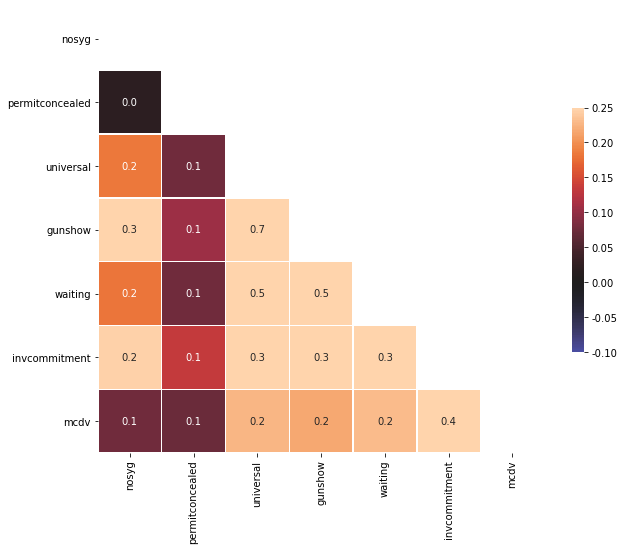

In [19]:
# Calculate the correlation matrix
corr = policies_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros(corr.shape)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap with 'sns.heatmap()'
ax = sns.heatmap(corr, annot=True, linewidths=.5, fmt='.1f', mask=mask, square = True, center=0, vmin=-0.1, vmax=0.25, cbar_kws={'shrink':.45, 'format':'%.2f'})

Interestingly, this plot of the correlations of these policies do not seem to be very high. Only `gunshow`-`universal` (0.7), `waiting`-`universal` (0.5), and `waiting`-`gunshow` (0.5), stick out. 

# 6. Conclusion

Overall, it isn't possible to conclude much further than what's in the models. To restate what we have:

- large effects with large standard error of the `selected_policies_index` on Violent Crime and Aggravated Assault rates, falling short of significance (p-values equalling 0.058, 0.053)
- small effect with large standard error of the `selected_policies_index` on Murder and Manslaughter rate, with a highly insignificant result
- mixed and inconsistent effects from a specific, very small, set of policies

From these results, it appears that state-level gun control policies are not particularly effective at reducing Violent Crime, though they don't appear to increase it. 

Some thoughts on why this might be:

- States can only control what happens within their borders, not in neighboring states. It would be very easy to simply buy guns in a loosely-regulated state and move them illegally into one with strict laws. 
- The US has a massive supply of guns in circulation and properly-maintained firearms are durable goods. Even if official supply is reduced it would likely take time for stocks to diminish.


## Extensions

Andrew Benson, a friend of mine, has suggested ways to improve the model by reducing bias and accounting for other variables. While they are too time-consuming to do now, I may likely return to the project later and see what results are reached. Some useful improvements include:

- controlling for the lowest level of gun restrictions among a state's neighbors
- controlling for lags of crime rate (due to persistence in crime)
- controlling for lags in gun control levels (due to these taking time to impact gun supply)
- assess whether state quadratic time trends are unnecessary
- instrumenting for partisan holdings of state legislatures 

All of these will improve model estimation, but require substantial extra work (neighboring states, reassessment of quadratic time trends, partisan legislature control) or reducing the sample size to lag variables, and I skipped them to move on to other projects. 

I would, however, like to thank Benson for talking about my model with me, and I do hope to make these improvements in the future. 